In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 19.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
import itertools
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

seed_value = 123

<h2 style="font-family:courier;"> 1.2 Data Import </h2>

In [ ]:
!git clone https://github.com/moudmid/Masters.git
!unzip /content/Masters/Solar_energy/solar_data.zip

Cloning into 'Masters'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 29 (delta 16), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (29/29), 9.33 MiB | 8.51 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Archive:  /content/Masters/Solar_energy/solar_data.zip
  inflating: Solar_Energy_Production.csv  


In [ ]:
df= pd.read_csv('/content/Solar_Energy_Production.csv')
df2= pd.read_csv('/content/Masters/Solar_energy/Solar_Photovoltaic_Sites.csv')
energy_production=  pd.merge(df2,df,on="id",suffixes=('', '_y'))
energy_production=energy_production.sort_values(by=['id','date'])
energy_production= energy_production.reset_index(drop=True)
energy_production['date'] = pd.to_datetime(energy_production['date'])
energy_production.head()


,id,name,address_orig,address,latitude,longitude,location,installationDate,public_url,manufacturerName,...,City Quadrants,Ward Boundaries,Calgary Communities,name_y,address_y,date,kWh,public_url_y,installationDate_y,uid
0,164440.0,Southland Leisure Centre,Southland Drive Southwest 2000,2000 SOUTHLAND DR SW,50.962485,-114.108472,"(50.96248466, -114.1084722)",2015/09/01,https://monitoringpublic.solaredge.com/solared...,RENESOLA,...,1,8,66,Southland Leisure Centre,2000 SOUTHLAND DR SW,2015-09-01 14:30:00,27.805,https://monitoring.solaredge.com/solaredge-web...,2015/09/01,1644402015-09-01 14:30:00
1,164440.0,Southland Leisure Centre,Southland Drive Southwest 2000,2000 SOUTHLAND DR SW,50.962485,-114.108472,"(50.96248466, -114.1084722)",2015/09/01,https://monitoringpublic.solaredge.com/solared...,RENESOLA,...,1,8,66,Southland Leisure Centre,2000 SOUTHLAND DR SW,2015-09-01 15:30:00,30.559,https://monitoring.solaredge.com/solaredge-web...,2015/09/01,1644402015-09-01 15:30:00
2,164440.0,Southland Leisure Centre,Southland Drive Southwest 2000,2000 SOUTHLAND DR SW,50.962485,-114.108472,"(50.96248466, -114.1084722)",2015/09/01,https://monitoringpublic.solaredge.com/solared...,RENESOLA,...,1,8,66,Southland Leisure Centre,2000 SOUTHLAND DR SW,2015-09-01 16:30:00,23.613,https://monitoring.solaredge.com/solaredge-web...,2015/09/01,1644402015-09-01 16:30:00
3,164440.0,Southland Leisure Centre,Southland Drive Southwest 2000,2000 SOUTHLAND DR SW,50.962485,-114.108472,"(50.96248466, -114.1084722)",2015/09/01,https://monitoringpublic.solaredge.com/solared...,RENESOLA,...,1,8,66,Southland Leisure Centre,2000 SOUTHLAND DR SW,2015-09-01 17:30:00,15.257,https://monitoring.solaredge.com/solaredge-web...,2015/09/01,1644402015-09-01 17:30:00
4,164440.0,Southland Leisure Centre,Southland Drive Southwest 2000,2000 SOUTHLAND DR SW,50.962485,-114.108472,"(50.96248466, -114.1084722)",2015/09/01,https://monitoringpublic.solaredge.com/solared...,RENESOLA,...,1,8,66,Southland Leisure Centre,2000 SOUTHLAND DR SW,2015-09-01 18:30:00,7.896,https://monitoring.solaredge.com/solaredge-web...,2015/09/01,1644402015-09-01 18:30:00


In [ ]:
'''
locations = df['id'].unique()
databl = df2.groupby('id')
locd = databl.get_group(locations[4])
locd['date'] = pd.to_datetime(locd.Date)
locd.sort_values(by='date',inplace=True)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(locd['date'],locd['kWh'])
plt.grid(True)
plt.show()
'''

AttributeError: ignored

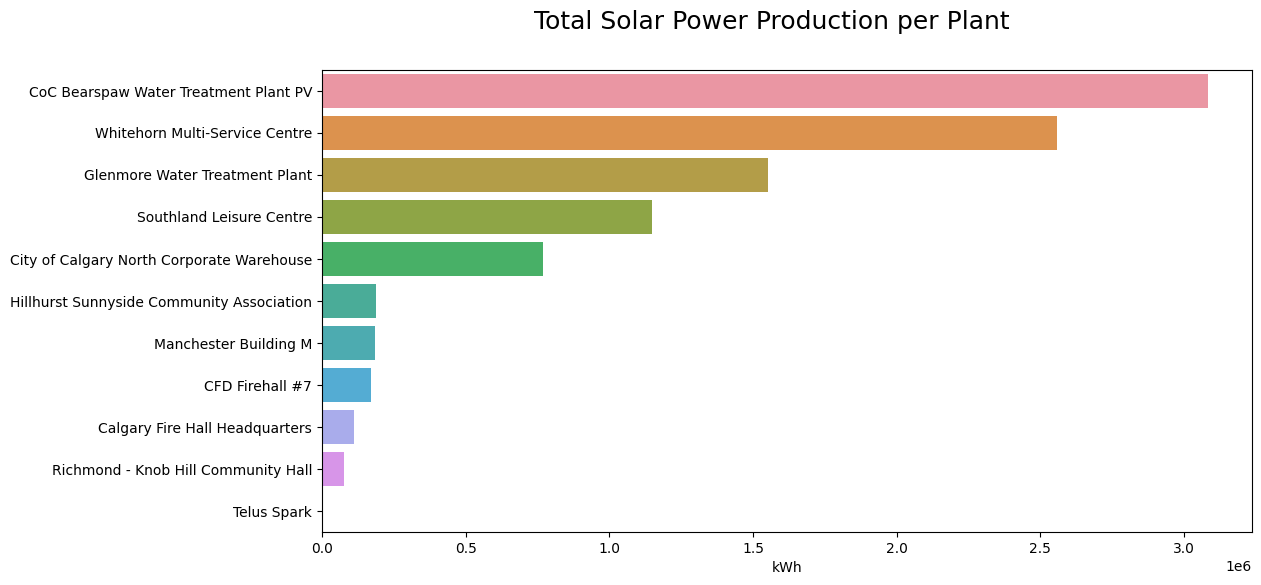

In [ ]:
totoal_plant_production = energy_production.groupby('name')[['kWh']].sum().sort_values('kWh', ascending=False).reset_index()

fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(totoal_plant_production, x='kWh', y='name')
ax.set(ylabel=None)

fig.suptitle('Total Solar Power Production per Plant', fontsize=18)
fig.show()

In [ ]:
# Data for Monthly Heatmap per Plant
total_monthly_energy = (energy_production
              .loc[:, ['date', 'name','kWh']]
              .set_index('date')
              .groupby('name').resample('M').sum(numeric_only=True).reset_index().set_index('date')
              .groupby('name').resample('M').asfreq().fillna(0).drop(columns='name').reset_index()
              .pivot_table(index='name', columns='date', values='kWh')
        )

total_monthly_energy = total_monthly_energy.div(total_monthly_energy.max(axis=1), axis=0)

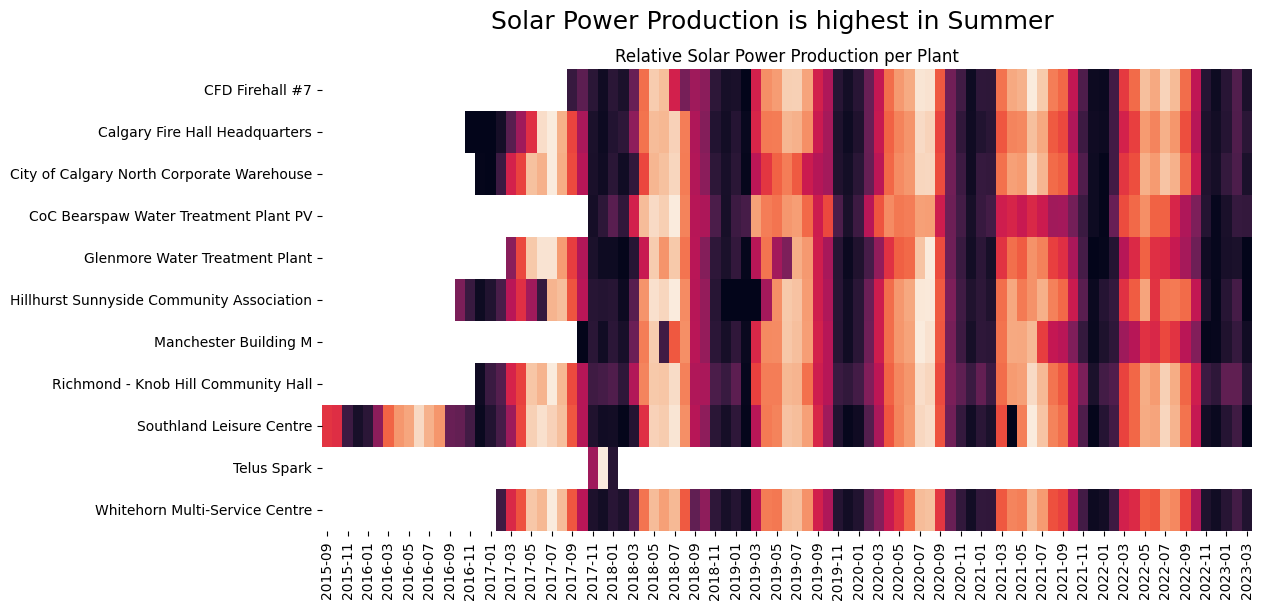

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))

sns.heatmap(total_monthly_energy, cbar=False)

x_dates = [x.get_text().replace('T00:00:00.000000000', '')[:-3] for x in ax.get_xticklabels()]
ax.set_xticklabels(labels=x_dates)
ax.set(xlabel=None)
ax.set(ylabel=None)

fig.suptitle('Solar Power Production is highest in Summer', fontsize=18)
plt.title('Relative Solar Power Production per Plant')

fig.show()


<h1 style="font-family:courier;"> III. Time Series Modelling </h1>   
<h2 style="font-family:courier;"> 3.1 Experiement Setup </h2>

<div style="font-family:courier; font-size:18px;">
For this experiment we limit us to a univariate time series modelling and choose the <b>Whitehorn Multi-Service Centre</b> power plant for modelling.
    
</div>

In [ ]:
## Experiment Setup
### Data Parameters
frequency = ['h', 'd', 'W', 'M'][1]
plant_name = "Whitehorn Multi-Service Centre"
year_start = 2017

regression_models = {
    'Lin_Reg': LinearRegression,
}

statistical_models = {
    'AutoARIMA': AutoARIMA,
}

## Evaluation
metrics = {
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error
}

<h2 style="font-family:courier;"> 3.2 Data Preprocessing </h2>

In [ ]:
plant_data = (energy_production
              .loc[energy_production.name == plant_name, ['date', 'kWh']]
              .set_index('date')
              .resample(frequency).sum()
              .resample(frequency).asfreq().fillna(0)
        )

plant_data.head()

,kWh
date,
2017-02-13,336.903
2017-02-14,677.414
2017-02-15,799.390
2017-02-16,1140.197
2017-02-17,1399.423


<h2 style="font-family:courier;"> 3.3 Check for Seasonality </h2>
+ Data has a yearly seasonality

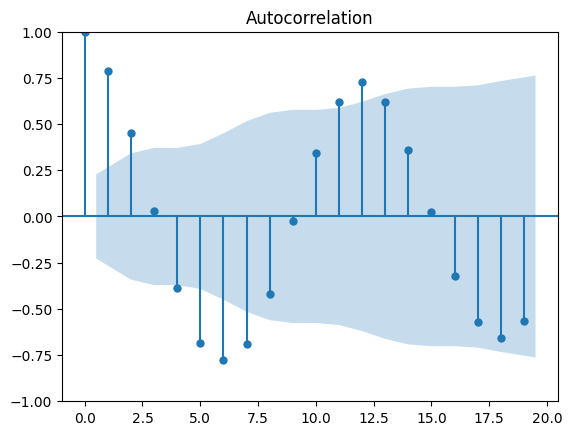

In [ ]:
plot_acf(plant_data.resample("M").sum())
plt.show()

<h2 style="font-family:courier;"> 3.4 Train Test Split </h2>

+ 1 year of weekly data for models comparison

In [ ]:

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
X,y = split_sequence(list(plant_data.kWh),30)

In [ ]:
X_train,X_test,y_train,y_test = X[:int(0.9*len(X))],X[int(0.9*len(X)):],y[:int(0.9*len(y))],y[int(0.9*len(y)):]

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

n_steps = 30
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200)


Epoch 1/200
69/69 [==============================] - 1s 8ms/step - loss: 1425103.5000
Epoch 2/200
69/69 [==============================] - 1s 8ms/step - loss: 901761.2500
Epoch 3/200
69/69 [==============================] - 1s 7ms/step - loss: 765550.6875
Epoch 4/200
69/69 [==============================] - 1s 8ms/step - loss: 606819.1250
Epoch 5/200
69/69 [==============================] - 1s 8ms/step - loss: 592782.2500
Epoch 6/200
69/69 [==============================] - 1s 8ms/step - loss: 599023.7500
Epoch 7/200
69/69 [==============================] - 1s 8ms/step - loss: 559853.9375
Epoch 8/200
69/69 [==============================] - 1s 8ms/step - loss: 730702.6875
Epoch 9/200
69/69 [==============================] - 1s 9ms/step - loss: 780315.5625
Epoch 10/200
69/69 [==============================] - 1s 11ms/step - loss: 630609.6250
Epoch 11/200
69/69 [==============================] - 1s 15ms/step - loss: 479853.0625
Epoch 12/200
69/69 [==============================] - 1s 17m

In [ ]:
lstm_pred = model.predict(X_test)

7/7 [==============================] - 0s 3ms/step


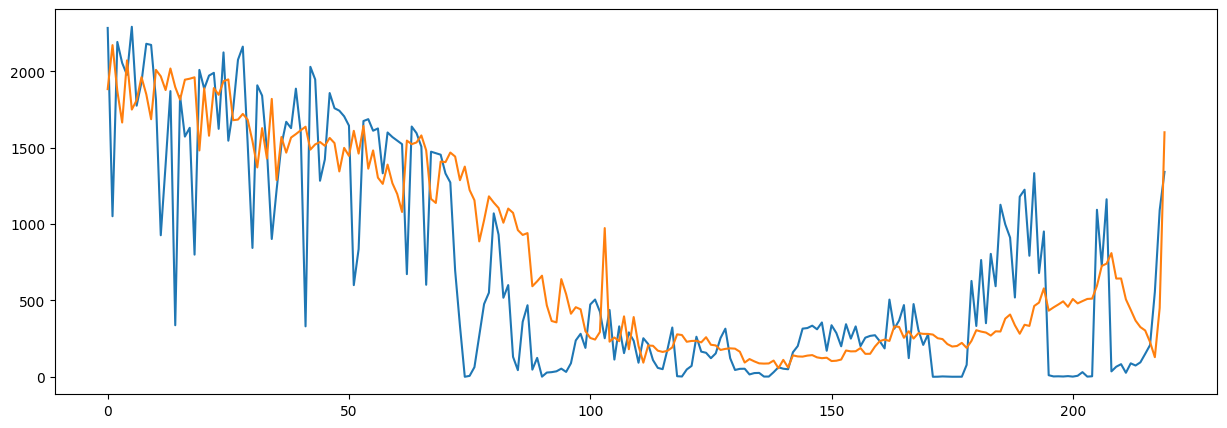

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(y_test)
ax.plot(lstm_pred)


In [ ]:
lstm_pred.reshape(220)

array([1883.5326  , 2171.583   , 1870.4972  , 1664.8474  , 2071.7495  ,
       1749.7054  , 1810.8541  , 1961.9775  , 1849.4166  , 1686.4656  ,
       2009.5149  , 1967.4191  , 1877.3529  , 2018.5052  , 1896.7825  ,
       1814.5492  , 1945.1669  , 1951.7006  , 1960.9552  , 1481.8914  ,
       1888.9695  , 1578.2091  , 1890.2444  , 1846.0382  , 1935.2056  ,
       1947.1177  , 1680.1378  , 1684.0104  , 1721.1171  , 1683.8699  ,
       1543.3615  , 1370.7166  , 1627.9166  , 1429.3859  , 1819.4178  ,
       1287.9775  , 1569.9684  , 1467.5566  , 1566.3362  , 1589.0743  ,
       1613.812   , 1637.247   , 1487.3339  , 1521.556   , 1537.1785  ,
       1512.2438  , 1564.1066  , 1530.1069  , 1344.4196  , 1498.7042  ,
       1446.4375  , 1610.5414  , 1461.3123  , 1641.9889  , 1362.674   ,
       1482.1498  , 1303.8473  , 1263.0397  , 1389.2955  , 1267.3856  ,
       1196.81    , 1079.266   , 1546.369   , 1523.0297  , 1534.3549  ,
       1580.2281  , 1482.7057  , 1164.7817  , 1138.1036  , 1409.

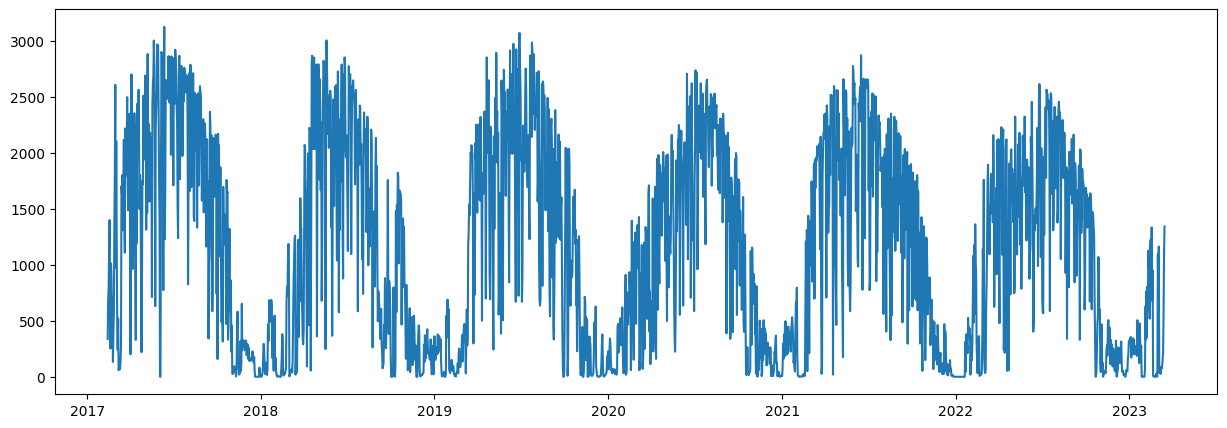

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(plant_data)


<h1 style="font-family:courier;"> V. Conclusion </h1>   

<div style="font-family:courier; font-size:18px;">
    The <b>Light GBM</b> model delivered the best results on the MAE and the <b>Linear Regression</b> on the MSE.

    
Comparing the 3 different time series modelling approaches, the recursive method deliverred the best results.
</div>   
